In [251]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import signal
%matplotlib inline

##Import Reference Data

In [252]:
df_R = pd.read_csv(filepath_or_buffer = 'data/CompleteCal_shift.csv', parse_dates = [0], index_col = 0)
print df_R[:5]

                     CO_ppm  NO_ppb  NO2_ppb  O3_ppb
Date                                                
2014-07-07 07:13:00     0.2     1.1     13.4      28
2014-07-07 07:14:00     0.3     1.2     13.8      28
2014-07-07 07:15:00     0.3     1.2     14.4      26
2014-07-07 07:16:00     0.3     1.3     14.9      25
2014-07-07 07:17:00     0.3     7.8     17.9      24


##Import Pod Data

In [253]:
df_P = pd.io.parsers.read_csv(filepath_or_buffer = 'data/F9_clean.csv', parse_dates = [0], index_col = 0)
print df_P[:5]

                       UnixTime  e2v03  Temp    Rh
YYYY/MM/DD_HH:MM:SS                               
2014-08-15 00:00:05  1408060805     51  30.4  33.8
2014-08-15 00:00:13  1408060813     49  30.4  33.7
2014-08-15 00:00:21  1408060821     46  30.4  33.5
2014-08-15 00:00:29  1408060829     44  30.4  33.6
2014-08-15 00:00:38  1408060838     43  30.4  33.5


##Import Solar Data

In [254]:
df_S = pd.io.parsers.read_csv(filepath_or_buffer = 'data/zenith_angle.csv', parse_dates = [[0,1]], index_col = 0)
print df_S[:5]

                       Zenith Angle [degrees]
DATE (MM/DD/YYYY)_MST                        
2014-07-01 00:00:00                 117.14761
2014-07-01 00:01:00                 117.15116
2014-07-01 00:02:00                 117.15384
2014-07-01 00:03:00                 117.15565
2014-07-01 00:04:00                 117.15660


###Resample all of the data, so that the reference, pod, and solar data are in the same dataframe, and also average over a specified time.

In [255]:
resamp_time = '1Min'

In [256]:
df_all = pd.concat([df_R.O3_ppb.resample(resamp_time), df_P.resample(resamp_time), df_S.resample(resamp_time)], axis=1).dropna()
print df_all[:5]

                       O3_ppb      UnixTime      e2v03       Temp         Rh  \
DATE (MM/DD/YYYY)_MST                                                          
2014-08-15 00:00:00        40  1.408061e+09  45.142857  30.385714  33.571429   
2014-08-15 00:01:00        36  1.408061e+09  38.714286  30.400000  33.142857   
2014-08-15 00:02:00        39  1.408061e+09  40.875000  30.462500  33.087500   
2014-08-15 00:03:00        44  1.408061e+09  38.428571  30.500000  32.685714   
2014-08-15 00:04:00        43  1.408061e+09  35.571429  30.500000  32.471429   

                       Zenith Angle [degrees]  
DATE (MM/DD/YYYY)_MST                          
2014-08-15 00:00:00                 126.19866  
2014-08-15 00:01:00                 126.20367  
2014-08-15 00:02:00                 126.20766  
2014-08-15 00:03:00                 126.21065  
2014-08-15 00:04:00                 126.21264  


####Create 'days since start' feature.

In [257]:
df_all['days from start'] = df_all['UnixTime']
for i in range(0,len(df_all['UnixTime'])):
    df_all['days from start'][i] = int(df_all['UnixTime'][i]- df_all['UnixTime'][0])/86400

####Drop the names from all of the data to prepare it for filtering

In [258]:
df_fit = df_all.dropna()

In [259]:
rh_sm = None
temp_sm = None
ref_o3_sm = None
pod_o3_sm = None

#Declare the data column to filter.

#Filtering

####Define functions to plot the raw and filtered data

In [260]:
def plot_data(data,title):
    fig = plt.figure(figsize = (15,15))
    ax = fig.add_subplot(111)
    ax.plot(data[:5000], marker = '.')
    ax.set_title(title)

####Define a function that filters the data.

In [261]:
def plot_filter(b):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    ax2 = ax1.twinx()

    w, h = signal.freqz(b)
    w /= np.pi
    ax1.plot(w, 20 * np.log10(abs(h)), 'r-')
    ax2.plot(w[1:], -np.diff(np.unwrap(np.angle(h))), 'b-')
    ax2.set_ylim(bottom=0.)

    ax3 = fig.add_subplot(212)
    ax3.plot(w, 20 * abs(h), 'r-')

In [262]:
def hanning_window_fir_filtering(data_points, filter_minutes, y_data):
    #make a window (finite-impulse response method), 
    #second agrment is frequency in units where 1 is sampling frequency (1 means 1 cycle per minute, 0.2 is equal to a period of 5 minutes) 
    #first agrument is how many data points are in the window (frequency resolution) if you choose 100, there is a time delay by 50 data points
    samp_freq = 1.0/filter_minutes
    b = signal.firwin(data_points, samp_freq, window='hanning')
    
    impulse = np.zeros((100,))
    impulse[0] = 1.

    #replace impulse with my y values
    y = signal.lfilter(b, 1., y_data)
    
    #call the plotting functions for the filtered and raw data.
    plot_data(y_data,'Raw Data')
    plot_data(y,'Filtered Data')    
    
    #Call the impulse plotting function
    plot_filter(b)
    
    #Delete the shifted points from the new data
    y_final = np.delete(y_data, list(xrange(data_points)))
    
    return y_final

####Call the filtering function

Reference Data
[ 33.  33.  33.  30.  30.]


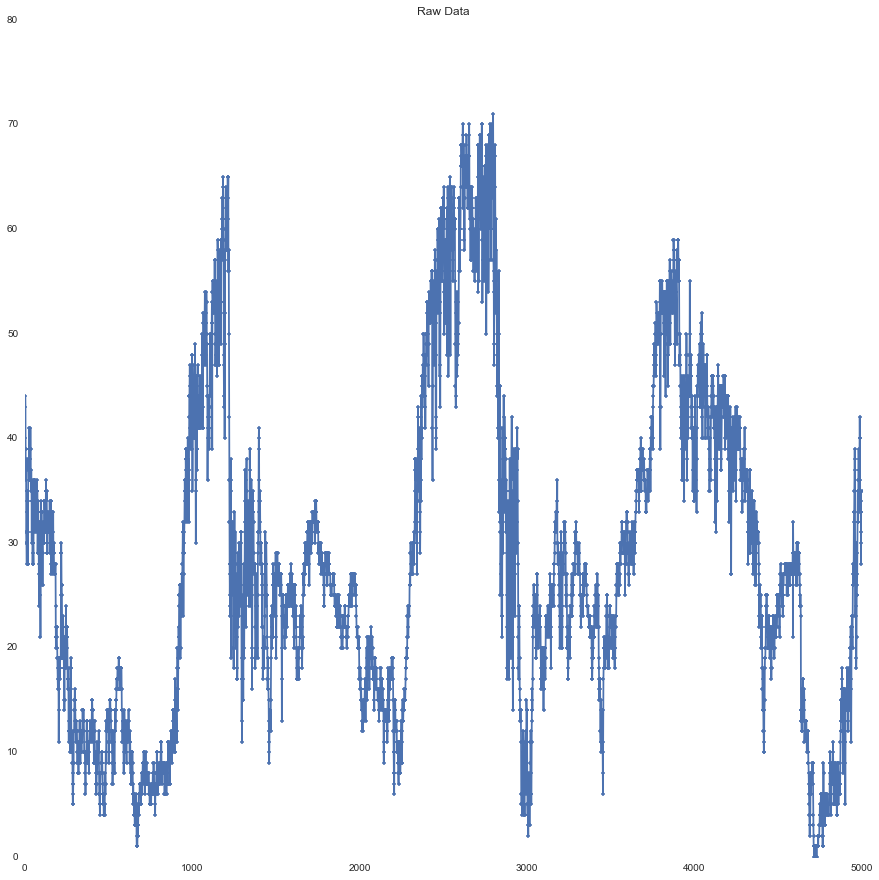

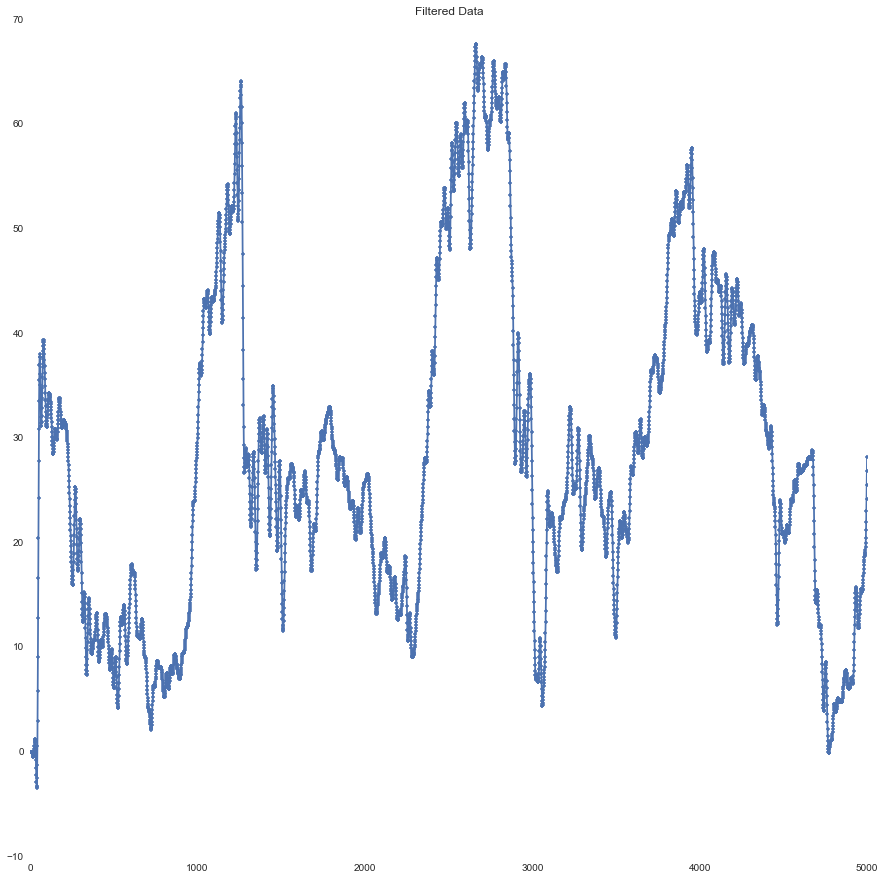

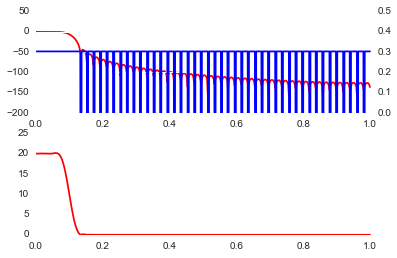

In [263]:
#Choose the number of data points in the window, and the number of minutes in the sampling period.
data_points = 100
filter_minutes = 10

ref_o3_sm = hanning_window_fir_filtering(data_points, filter_minutes, df_fit['O3_ppb'].values)
print 'Reference Data'
print ref_o3_sm[:5]

#pod_o3_sm = hanning_window_fir_filtering(data_points, filter_minutes, df_fit['e2v03'].values)
#print 'Pod Data'
#print pod_o3_sm[:5]

####Make a new dataframe without the offset rows, and append the new data into it.

In [264]:
df_short = df_fit.ix[data_points:]
print df_short[:5]

                       O3_ppb      UnixTime      e2v03       Temp         Rh  \
DATE (MM/DD/YYYY)_MST                                                          
2014-08-15 01:40:00        33  1.408067e+09  36.428571  26.700000  41.842857   
2014-08-15 01:41:00        33  1.408067e+09  37.285714  26.700000  42.142857   
2014-08-15 01:42:00        33  1.408067e+09  35.571429  26.685714  42.214286   
2014-08-15 01:43:00        30  1.408067e+09  36.000000  26.625000  42.187500   
2014-08-15 01:44:00        30  1.408067e+09  39.142857  26.600000  42.500000   

                       Zenith Angle [degrees]  days from start  
DATE (MM/DD/YYYY)_MST                                           
2014-08-15 01:40:00                 121.88546                0  
2014-08-15 01:41:00                 121.79701                0  
2014-08-15 01:42:00                 121.70776                0  
2014-08-15 01:43:00                 121.61773                0  
2014-08-15 01:44:00                 121.52692    

In [265]:
df_short['ref_o3_smooth'] = ref_o3_sm
#df_short['pod_o3_smooth'] = pod_o3_sm
print df_short[:5]

                       O3_ppb      UnixTime      e2v03       Temp         Rh  \
DATE (MM/DD/YYYY)_MST                                                          
2014-08-15 01:40:00        33  1.408067e+09  36.428571  26.700000  41.842857   
2014-08-15 01:41:00        33  1.408067e+09  37.285714  26.700000  42.142857   
2014-08-15 01:42:00        33  1.408067e+09  35.571429  26.685714  42.214286   
2014-08-15 01:43:00        30  1.408067e+09  36.000000  26.625000  42.187500   
2014-08-15 01:44:00        30  1.408067e+09  39.142857  26.600000  42.500000   

                       Zenith Angle [degrees]  days from start  ref_o3_smooth  
DATE (MM/DD/YYYY)_MST                                                          
2014-08-15 01:40:00                 121.88546                0             33  
2014-08-15 01:41:00                 121.79701                0             33  
2014-08-15 01:42:00                 121.70776                0             33  
2014-08-15 01:43:00                 121

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


##Make a csv file with the smoothed data

In [266]:
df_short.to_csv(path_or_buf = 'data/F9_filt_10mino3.csv')